Examine robbery, assault, sexual assault during the hours of 8pm-12am in areas around the UC Berkeley campus

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

In [64]:
bpd = pd.read_csv('berkeleypd.csv')
bpd.head(15)

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,19091845,THEFT FELONY (OVER $950),9/1/19 0:00,11:00,LARCENY,0,11/8/19 7:01,"BOLIVAR DR\rBerkeley, CA",BOLIVAR DR,Berkeley,CA
1,19092225,VANDALISM,10/11/19 0:00,5:00,VANDALISM,5,11/8/19 7:01,"HEARST AVE\rBerkeley, CA",HEARST AVE,Berkeley,CA
2,19051156,VEHICLE STOLEN,9/10/19 0:00,19:00,MOTOR VEHICLE THEFT,2,11/8/19 7:01,"100 MENLO PL\rBerkeley, CA",100 MENLO PL,Berkeley,CA
3,19091890,BURGLARY AUTO,9/8/19 0:00,2:00,BURGLARY - VEHICLE,0,11/8/19 7:01,"HASTE ST\rBerkeley, CA",HASTE ST,Berkeley,CA
4,19041310,VANDALISM,7/29/19 0:00,0:30,VANDALISM,1,11/8/19 7:01,"6000 CHABOLYN TE\rBerkeley, CA",6000 CHABOLYN TE,Berkeley,CA
5,19054596,ROBBERY,9/26/19 0:00,23:20,ROBBERY,4,11/8/19 7:01,"SPRUCE STREET & VINE ST\rBerkeley, CA",SPRUCE STREET & VINE ST,Berkeley,CA
6,19091705,VANDALISM,8/4/19 0:00,18:00,VANDALISM,0,11/8/19 7:01,"MILVIA ST\rBerkeley, CA",MILVIA ST,Berkeley,CA
7,19055811,NARCOTICS,10/2/19 0:00,14:48,DRUG VIOLATION,3,11/8/19 7:01,"2500 HASTE ST\rBerkeley, CA\r(37.866025, -122....",2500 HASTE ST,Berkeley,CA
8,19027566,ALCOHOL OFFENSE,5/20/19 0:00,13:50,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"1900 SHATTUCK AV\rBerkeley, CA\r(37.873687, -1...",1900 SHATTUCK AV,Berkeley,CA
9,19059507,BURGLARY AUTO,10/19/19 0:00,21:41,BURGLARY - VEHICLE,6,11/8/19 7:01,"3200 ADELINE ST\rBerkeley, CA\r(37.850385, -12...",3200 ADELINE ST,Berkeley,CA


In [56]:
bpd['CVLEGEND'].value_counts()

BURGLARY - VEHICLE        1198
LARCENY                   1130
DISORDERLY CONDUCT         309
VANDALISM                  273
ASSAULT                    270
MOTOR VEHICLE THEFT        254
FRAUD                      237
BURGLARY - RESIDENTIAL     183
ROBBERY                    169
FAMILY OFFENSE             142
LARCENY - FROM VEHICLE     140
DRUG VIOLATION             137
BURGLARY - COMMERCIAL      136
LIQUOR LAW VIOLATION        91
SEX CRIME                   69
WEAPONS OFFENSE             51
MISSING PERSON              34
RECOVERED VEHICLE           13
ARSON                       12
NOISE VIOLATION             11
KIDNAPPING                   5
ALL OTHER OFFENSES           4
DUI                          1
Name: CVLEGEND, dtype: int64

### Clean the data

In [65]:
""" convert date to datetime object, time as time """

bpd['EVENTDT'] = pd.to_datetime(bpd['EVENTDT'], format='%m/%d/%y %H:%M')
bpd['EVENTTM'] = pd.to_datetime(bpd['EVENTTM'], format='%H:%M')

In [66]:
# count = 0
for i in bpd.index:
    if '(' not in bpd.loc[i,'Block_Location']:
        bpd = bpd.drop(i)
        
for i in bpd.index:
    bpd.loc[i,'LatLon'] = bpd.loc[i,'Block_Location'][bpd.loc[i,'Block_Location'].find("(")+1:bpd.loc[i,'Block_Location'].rfind(")")]
    bpd.loc[i,'Lat'] = float(bpd.loc[i,'LatLon'][0:bpd.loc[i,'LatLon'].find(',')])
    bpd.loc[i,'Lon'] = float(bpd.loc[i,'LatLon'][bpd.loc[i,'LatLon'].find(',')+2:])

In [67]:
bpd[bpd['City'] != 'Berkeley']

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State,LatLon,Lat,Lon


In [68]:
""" remove unneeded columns """
bpd = bpd.drop(['CASENO', 'State', 'Block_Location', 'BLKADDR', 'City'], axis=1) 
bpd.head()

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,LatLon,Lat,Lon
7,NARCOTICS,2019-10-02,1900-01-01 14:48:00,DRUG VIOLATION,3,11/8/19 7:01,"37.866025, -122.258623",37.866025,-122.258623
8,ALCOHOL OFFENSE,2019-05-20,1900-01-01 13:50:00,LIQUOR LAW VIOLATION,1,11/8/19 7:01,"37.873687, -122.268616",37.873687,-122.268616
9,BURGLARY AUTO,2019-10-19,1900-01-01 21:41:00,BURGLARY - VEHICLE,6,11/8/19 7:01,"37.850385, -122.270897",37.850385,-122.270897
10,BURGLARY AUTO,2019-09-10,1900-01-01 15:00:00,BURGLARY - VEHICLE,2,11/8/19 7:01,"37.868663, -122.301325",37.868663,-122.301325
11,DISTURBANCE,2019-05-24,1900-01-01 01:25:00,DISORDERLY CONDUCT,5,11/8/19 7:01,"37.856111, -122.260248",37.856111,-122.260248


In [30]:
min(bpd['EVENTDT'].dt.date)

datetime.date(2019, 5, 11)

### insert map of crimes here

### change detection

In [607]:
bpd['EVENTDT'] = pd.to_datetime(bpd['EVENTDT'], format='%m/%d/%y %H:%M')
bpd['EVENTTM'] = pd.to_datetime(bpd['EVENTTM'], format='%H:%M')

In [608]:
# Round time to the nearest hour
def timeround(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 60, seconds=tm.second) 
    return tm

bpd['TIME_1HR'] = [timeround(bpd['EVENTTM'][i]) for i in range(len(bpd['EVENTTM']))]

# Time only 
bpd['TIME_1HR'] = bpd['TIME_1HR'].dt.time

# Date only
bpd['EVENTDT'] = bpd['EVENTDT'].dt.date

In [510]:
crime_list = ['ASSAULT', 'ROBBERY']

In [511]:
bpd = bpd[bpd['CVLEGEND'].isin(crime_list)]

In [512]:
# Total number of police calls during each one-hour window
n_days = bpd.groupby('TIME_1HR')['EVENTDT'].nunique()
# Total number of days where at least a call happened during a given one-hour window
n_calls = bpd.groupby('TIME_1HR')['EVENTDT'].count()
# Average number of calls during each hour of the day
mean_calls = n_calls/n_days
mean_calls = pd.DataFrame({'time':mean_calls.index, 'ave_calls':mean_calls.values})

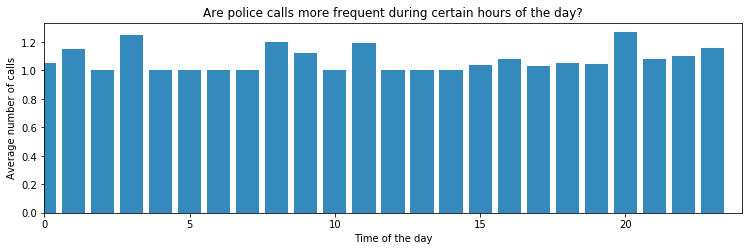

In [513]:
# Plot out 
plt.figure(figsize=(12.5, 3.5))
n_mean_calls = len(mean_calls)
plt.bar(np.arange(n_mean_calls), mean_calls['ave_calls'], color="#348ABD")
plt.xlabel("Time of the day")
plt.ylabel("Average number of calls")
plt.title("Are police calls more frequent during certain hours of the day?")
plt.xlim(0, n_mean_calls)

plt.savefig('hour_of_day.png')

In [514]:
with pm.Model() as model:
    alpha = 1.0/mean_calls['ave_calls'].mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_mean_calls - 1)

In [515]:
with model:
    idx = np.arange(n_mean_calls) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [516]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=mean_calls['ave_calls'])

In [517]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3245.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [469]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


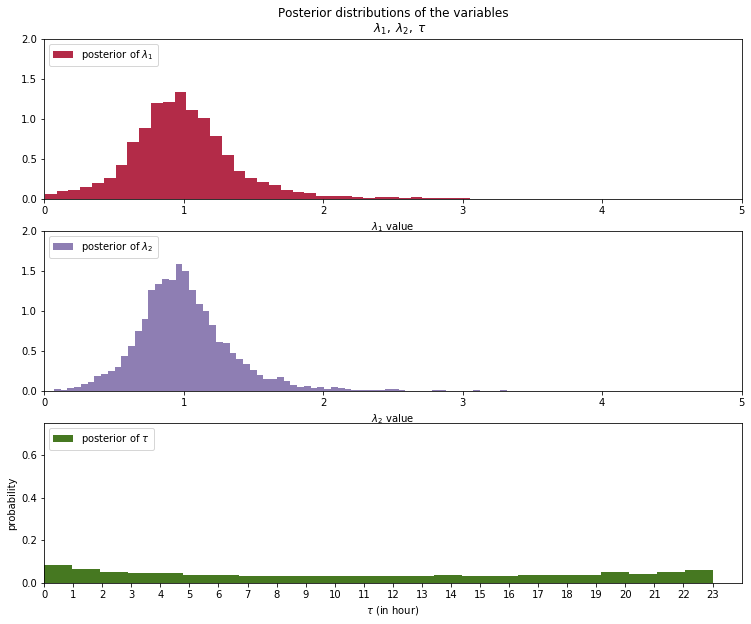

In [470]:
plt.figure(figsize=(12.5, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=100, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
# divide each tau value by the # of samples to get the probability of that value 
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples) 
plt.hist(tau_samples, bins=n_mean_calls, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.) 
plt.xticks(np.arange(n_mean_calls))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([0, 24])
plt.xlabel(r"$\tau$ (in hour)")
plt.ylabel("probability")

plt.savefig('change.png')

In [518]:
bpd.head(3)

,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,TIME_1HR
5,ROBBERY,2019-09-26,1900-01-01 23:20:00,ROBBERY,4,11/8/19 7:01,23:00:00
30,ASSAULT/BATTERY MISD.,2019-07-04,1900-01-01 20:30:00,ASSAULT,4,11/8/19 7:01,20:00:00
54,ASSAULT/BATTERY FEL.,2019-10-01,1900-01-01 02:00:00,ASSAULT,2,11/8/19 7:01,02:00:00


### Day in a week

In [479]:
week_hr = pd.crosstab(bpd['TIME_1HR'], bpd['CVDOW'])

In [480]:
week_hr['hour'] = week_hr.index

In [484]:
week_hr_long = pd.melt(week_hr,id_vars="hour",var_name='CVDOW', value_name='counts')

In [493]:
week_hr_long['CVDOW'] = week_hr_long['CVDOW'].replace({0: 'Sun', 1: 'Mon', 2: 'Tues', 3: 'Wed', 4: 'Thurs',
                                                       5: 'Fri', 6: 'Sat'})

Text(24.78319010416667, 0.5, 'Number of calls (robberies + assaults)')

<Figure size 1440x1080 with 0 Axes>

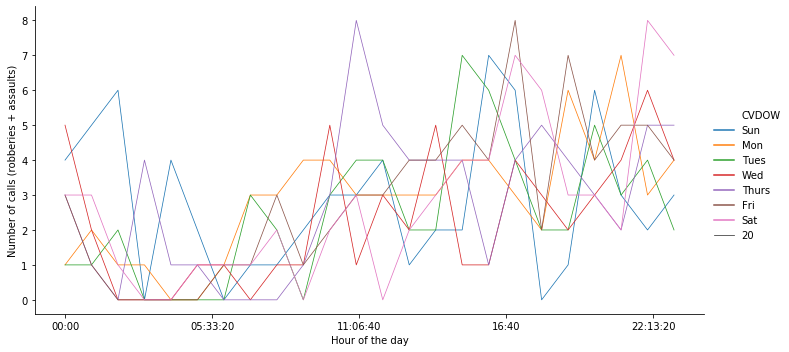

In [524]:
plt.figure(figsize=(20, 15))
sns.relplot(x="hour", y="counts", hue="CVDOW",
                size=20, aspect=2, facet_kws=dict(sharex=True),
                kind="line", legend="full", data=week_hr_long)
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls (robberies + assaults)')

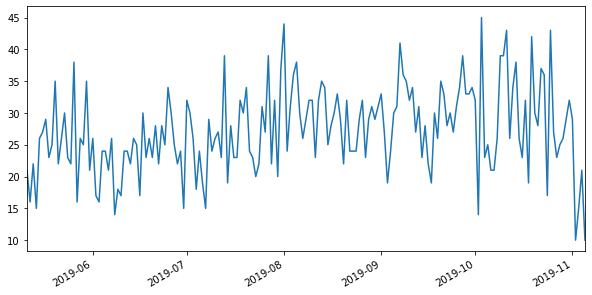

In [31]:
plt.figure(figsize=(10, 5))
bpd['EVENTDT'].value_counts().plot()

In [46]:
# Use FiveThirtyEight-style plots
import matplotlib.style as style
style.use('fivethirtyeight')


In [47]:
day = bpd['EVENTDT'].value_counts()
day = pd.DataFrame(day).reset_index()
day.columns = ['date', 'count']

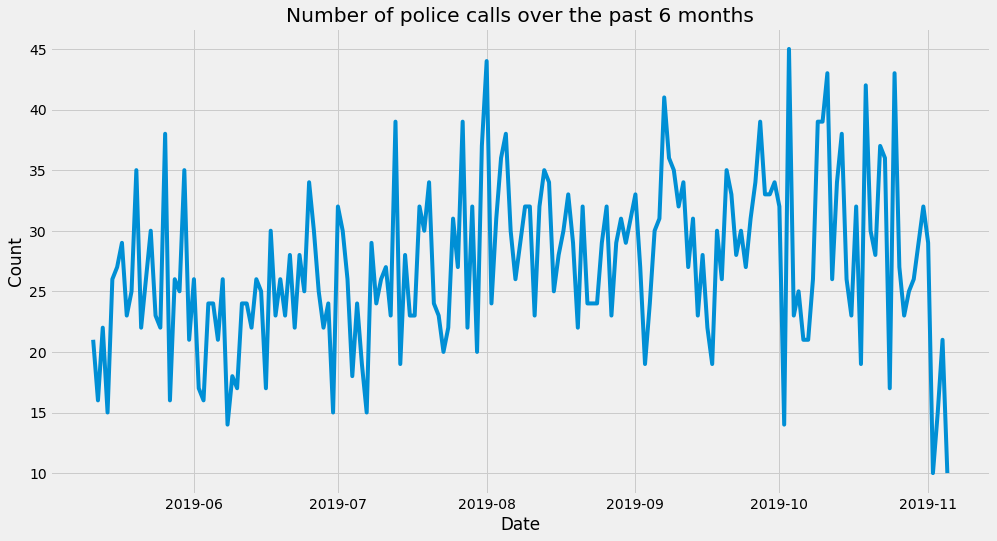

<Figure size 432x288 with 0 Axes>

In [54]:
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="count", data=day)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of police calls over the past 6 months')
plt.show()
plt.savefig('trend.png')

In [69]:
bpd['EVENTDT'].value_counts().mean() 

27.201117318435752

In [58]:
with pm.Model() as model:
    alpha = 1.0/bpd['EVENTDT'].value_counts().mean() 
    lam = pm.Exponential("lambda", alpha)
    observation = pm.Poisson("obs", lam, observed=bpd['EVENTDT'].value_counts())

In [59]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [lambda]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:03<00:00, 8121.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [61]:
lam_samples = trace['lambda']

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, '$\\lambda$ value')

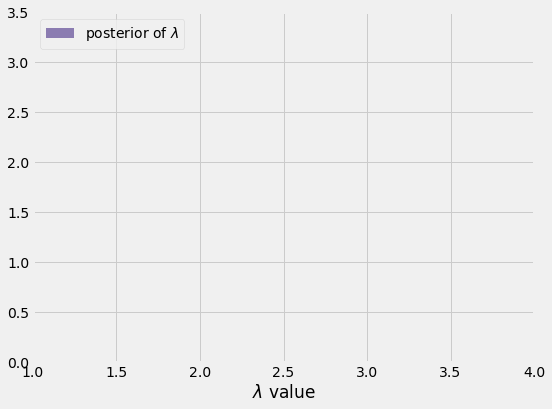

In [62]:
plt.figure(figsize=(8, 6))
plt.hist(lam_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([1, 4])
plt.ylim([0, 3.5])
plt.xlabel("$\lambda$ value", fontsize=17)

In [667]:
day_counts = bpd['EVENTDT'].value_counts().values

In [668]:
day_counts = pd.Series(day_counts)

In [669]:
day_freq = day_counts.value_counts()

In [670]:
day_freq = pd.DataFrame(day_freq).reset_index()
day_freq.columns = ['calls', 'frequency']

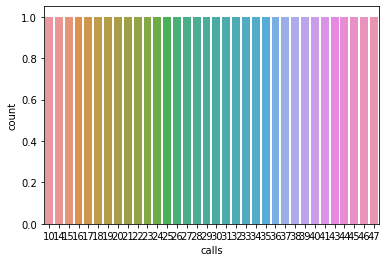

In [671]:
sns.countplot(x='calls', data=day_freq)

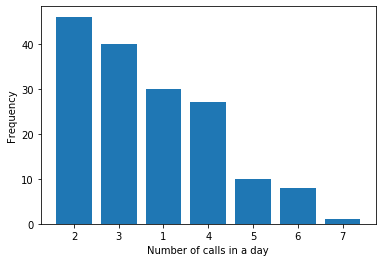

In [594]:
height = day_freq['frequency']
bars = day_freq['calls']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)

# Lables
plt.xlabel('Number of calls in a day')
plt.ylabel('Frequency')
    
# Show graphic
plt.show()

In [629]:
date_crime = pd.crosstab(bpd['EVENTDT'], bpd['CVLEGEND'])

date_crime  = date_crime[['ASSAULT', 'ROBBERY', 'SEX CRIME']]

date_crime['date'] = date_crime.index

date_crime_long = pd.melt(date_crime,id_vars="date",var_name='CVLEGEND', value_name='counts')

plt.figure(figsize=(20, 15))
sns.relplot(x="date", y="counts", row="CVLEGEND",
                size=10, aspect=1.5, facet_kws=dict(sharex=True),
                kind="line", legend="full", data=date_crime_long)
plt.xlabel('Date')
plt.ylabel('Number of calls')

Text(34.170277777777784, 0.5, 'Number of calls')

<Figure size 1440x1080 with 0 Axes>

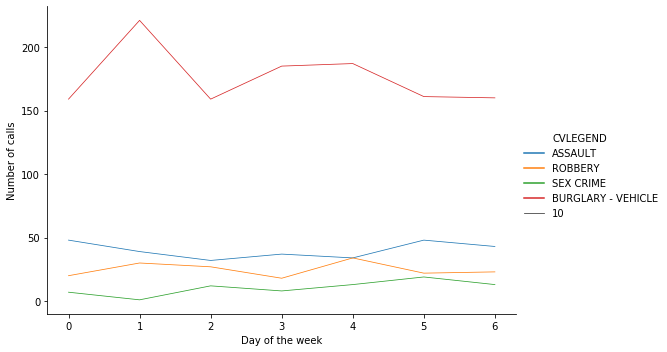

In [665]:
day_crime = pd.crosstab(bpd['CVDOW'], bpd['CVLEGEND'])

day_crime  = day_crime[['ASSAULT', 'ROBBERY', 'SEX CRIME', 'BURGLARY - VEHICLE']]

day_crime['day'] = day_crime.index

day_crime_long = pd.melt(day_crime,id_vars="day",var_name='CVLEGEND', value_name='counts')

plt.figure(figsize=(20, 15))
sns.relplot(x="day", y="counts", hue="CVLEGEND",
                size=10, aspect=1.5, facet_kws=dict(sharex=True),
                kind="line", legend="full", data=day_crime_long)
plt.xlabel('Day of the week')
plt.ylabel('Number of calls')

### Crime rates change over year?
Results are nonsense...

In [640]:
with pm.Model() as model:
    alpha = 1.0/date_crime['ASSAULT'].mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_mean_calls - 1)

In [641]:
with model:
    idx = np.arange(len(date_crime['ASSAULT'])) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [642]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=date_crime['ASSAULT'])

In [643]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:07<00:00, 3801.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [649]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


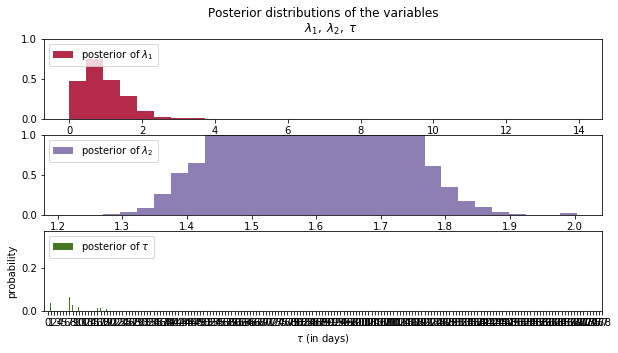

In [652]:
plt.figure(figsize=(10, 5))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
# divide each tau value by the # of samples to get the probability of that value 
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples) 
plt.hist(tau_samples, bins=len(date_crime['ASSAULT']), alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.) 
plt.xticks(np.arange(len(date_crime['ASSAULT'])))

plt.legend(loc="upper left")
#plt.ylim([0, .75])
#plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");